# DA3 Assignment 1

In [1]:
# Importing libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

In [2]:
# Importing dataset, printing shape and showing first 5 observations
data = pd.read_csv('morg-2014-emp.csv')
print(data.shape)
data.head()

(149316, 23)


,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


In [3]:
# Selecting Registed Nurses as the occupation and assigning it to a new df rnurses, showing the amount of observations and checking column info
rnurses = data.loc[data['occ2012'] == 3255]
print(rnurses.shape)
rnurses.info()

(3455, 23)
<class 'pandas.core.frame.DataFrame'>
Index: 3455 entries, 37 to 149242
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3455 non-null   int64  
 1   hhid        3455 non-null   int64  
 2   intmonth    3455 non-null   object 
 3   stfips      3455 non-null   object 
 4   weight      3455 non-null   float64
 5   earnwke     3455 non-null   float64
 6   uhours      3455 non-null   int64  
 7   grade92     3455 non-null   int64  
 8   race        3455 non-null   int64  
 9   ethnic      191 non-null    float64
 10  age         3455 non-null   int64  
 11  sex         3455 non-null   int64  
 12  marital     3455 non-null   int64  
 13  ownchild    3455 non-null   int64  
 14  chldpres    3455 non-null   int64  
 15  prcitshp    3455 non-null   object 
 16  state       3455 non-null   object 
 17  ind02       3455 non-null   object 
 18  occ2012     3455 non-null   int64  
 19  class       3455 n

In [21]:
# Creating hourly wage variable, ln hourly wage variable, and quadratic variable for age
rnurses['hrwage'] = rnurses['earnwke'] / rnurses['uhours']
rnurses['lnhrwage'] = np.log(rnurses['hrwage'])
rnurses['agesq'] = rnurses['age'] ** 2

In [5]:
# Checking race column value counts
rnurses['race'].value_counts()

race
1     2837
2      320
4      249
5       12
3       11
6        8
7        8
8        3
9        3
13       1
21       1
16       1
10       1
Name: count, dtype: int64

In [6]:
# According to dataset, 1=white, 2=black, and 4=asian. Creating dummy variables to account for black and asian
rnurses['black'] = (rnurses['race'] == 2).astype(int)
rnurses['asian'] = (rnurses['race'] == 4).astype(int)

In [7]:
# Checking sex column value counts
rnurses['sex'].value_counts()

sex
2    3125
1     330
Name: count, dtype: int64

In [8]:
# 1 = male, 2 = female. Creating `female` dummy variable
rnurses['female'] = (rnurses['sex'] == 2).astype(int)

In [9]:
# Chceking ownchild value counts
rnurses.ownchild.value_counts()

ownchild
0    2009
2     569
1     566
3     246
4      54
5       9
6       2
Name: count, dtype: int64

In [10]:
# Creating dummy variables for number of children present
rnurses['one_child'] = (rnurses['ownchild'] == 1).astype(int) # 1 if one child present 0 if not
rnurses['two_child'] = (rnurses['ownchild'] == 2).astype(int) # 1 if two children present 0 if not
rnurses['three_plus_child'] = (rnurses['ownchild'] >= 3).astype(int) # 1 if three or more childred present 0 if not

In [11]:
# Checking marital value counts
rnurses.marital.value_counts()

marital
1    2212
7     590
5     462
6      71
4      54
3      38
2      28
Name: count, dtype: int64

In [12]:
# Numers are defined as follows: 1 and 2 = married, 3 and 6 = separated, 4 = widowed, 5 = divorced, and 7 = never married

# Creating dummy variable for currently single which includes the values for 3, 6 (separated), 5 (divorced)
rnurses['now_single'] = rnurses['marital'].isin([3, 5, 6]).astype(int)

# Creating dummy variable for 7 (never married)
rnurses['never_married'] = (rnurses['marital'] == 7).astype(int)

In [13]:
# Checking grade92 column value counts
rnurses.grade92.value_counts()

grade92
43    1888
42     624
41     485
44     256
40      97
39      44
45      38
46      16
38       2
33       1
34       1
31       1
37       1
35       1
Name: count, dtype: int64

In [14]:
# This column measures the amount of education. 43 = bachelors degree, >43 is graduate and/or phd, 41 and 42 are associate degrees, and <41 is college not completed

# Creating dummy variable for associate degrees
rnurses['associate'] = rnurses['grade92'].isin([41, 42]).astype(int)

# Creating dummy variable for higher level education (above 43)
rnurses['higher_edu'] = (rnurses['grade92'] > 43).astype(int)

# Creating dummy variable for below bachelors and associate (below 41)
rnurses['no_degree'] = (rnurses['grade92'] < 41).astype(int)

In [15]:
# Checking prcitshp value counts
rnurses.prcitshp.value_counts()

prcitshp
Native, Born In US                        3012
Foreign Born, US Cit By Naturalization     307
Foreign Born, Not a US Citizen              98
Native, Born Abroad Of US Parent(s)         31
Native, Born in PR or US Outlying Area       7
Name: count, dtype: int64

The column prcitshp shows whether or not the person in question is a native citizen, naturalized, or not a US citizen. Not deemed to be significant for this analysis given low amount of observations of non-US citizens

In [16]:
# Checking unionmme value counts
rnurses.unionmme.value_counts()

unionmme
No     2845
Yes     610
Name: count, dtype: int64

In [18]:
# This checks whether or not the person in question is a member of a union or some union-type entity. Changing this column to a binary variable with 'Yes' = 1
rnurses['unionmme'] = (rnurses['unionmme'] == 'Yes').astype(int)

In [22]:
# Adding magic command for matplotlib
%matplotlib inline

In [28]:
# Descriptive stats for hourly wage
rnurses['hrwage'].describe()

count    3455.000000
mean       30.222456
std        14.427157
min         0.000937
25%        21.000000
50%        28.500000
75%        36.961500
max       293.268750
Name: hrwage, dtype: float64

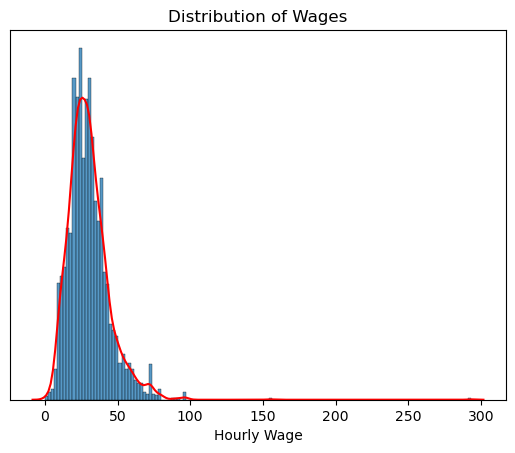

In [96]:
# Checking the distribution of hourly wages
ax = sns.histplot(rnurses, x='hrwage', stat='density')
sns.kdeplot(rnurses, x='hrwage', color="red")

ax.yaxis.set_visible(False)
plt.title('Distribution of Wages')
plt.xlabel('Hourly Wage');

The distribution of hourly wages has a right skew with a couple of extreme values. For the purposes of this analysis IQR will be used to drop any values considered to be outliers

In [31]:
# Removing hourly wage outliers

# Calculate the first quartile (Q1)
Q1 = rnurses['hrwage'].quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = rnurses['hrwage'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Filter rows within the IQR range for a specific column
rnurses_iqr = rnurses[(rnurses['hrwage'] >= Q1 - 1.5 * IQR) & (rnurses['hrwage'] <= Q3 + 1.5 * IQR)]

In [32]:
# Checking descriptive statistics for hourly wage on IQR df
rnurses_iqr['hrwage'].describe()

count    3341.000000
mean       28.727347
std        11.334243
min         0.000937
25%        20.620000
50%        27.884600
75%        36.000000
max        60.807500
Name: hrwage, dtype: float64

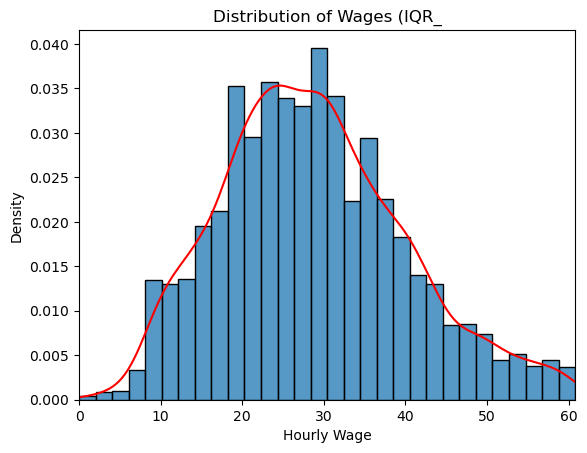

In [95]:
# Checking distribution of hourly wages on IQR df
ax = sns.histplot(rnurses_iqr, x='hrwage', stat='density')
sns.kdeplot(rnurses_iqr, x='hrwage', color="red")

plt.xlim(0, rnurses_iqr['hrwage'].max())
plt.title('Distribution of Wages (IQR_')
plt.xlabel('Hourly Wage');

The distribution of the plot is now much less skewed and approximates a normal distribution

### Regression Analysis - Linear vs Non-Linear
Hourly wages on Age

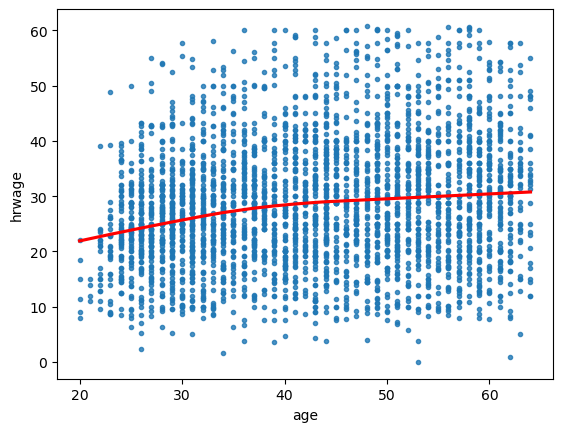

In [109]:
# Lowess
sns.regplot(rnurses_iqr, x = 'age', y = 'hrwage', marker= '.', fit_reg= True, lowess= True, line_kws = {'color':'red'});

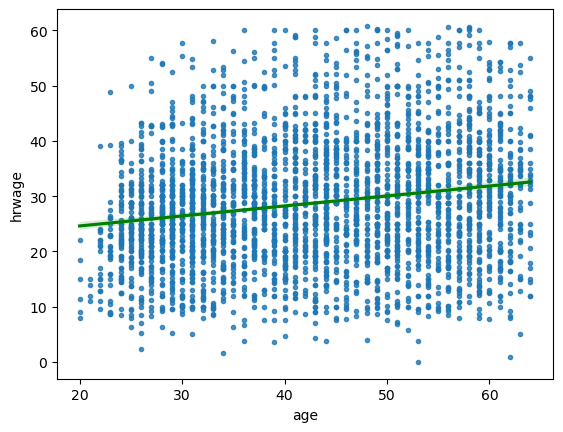

In [111]:
# OLS Simple Linear Regression
sns.regplot(rnurses_iqr, x = 'age', y = 'hrwage', marker = '.', line_kws={'color':'green'});

The Lowess and OLS plots are very similar and therefore a linear model should do a good job of finding a good fit